## MNE Visualization of EEG data

In [14]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import mne
from mne.channels import Layout as layout
from math import ceil
import matplotlib.ticker as mticker

In [55]:
no_coh_data_train = pd.read_csv('../data/final_dataset_all_no_coh_train.csv')

no_coh_data_test = pd.read_csv('../data/final_dataset_all_no_coh_test.csv')

df = pd.concat([no_coh_data_train,no_coh_data_test], ignore_index = True)

In [57]:
chs = {'FP1': [-0.03, 0.08],
       'FP2': [0.03, 0.08],
       'F7': [-0.073, 0.047],
       'F3': [-0.04, 0.041],
       'Fz': [0, 0.038],
       'F4': [0.04, 0.041],
       'F8': [0.073, 0.047],
       'T3': [-0.085, 0],
       'C3': [-0.045, 0],
       'Cz': [0, 0],
       'C4': [0.045, 0],
       'T4': [0.085, 0],
       'T5': [-0.073, -0.047],
       'P3': [-0.04, -0.041],
       'Pz': [0, -0.038],
       'P4': [0.04, -0.041],
       'T6': [0.07, -0.047],
       'O1': [-0.03, -0.08],
       'O2': [0.03, -0.08]}

channels = pd.DataFrame(chs).transpose()

Plot source : 
https://www.kaggle.com/code/lazygene/visualising-pre-processed-eeg-data

In [134]:
# plot the eeg to topomap using cmap to RdBu_r
def plot_eeg(lvl, pos, fig, channel_names=None, cmap='RdBu_r', 
             marker=None, marker_style=None, vmin=None, vmax=None, **kwargs):
    if 'mask' not in kwargs:
        mask = np.ones(lvl.shape[0], dtype='bool')
    else:
        mask = None
    axes = fig.subplots(1, 2, gridspec_kw={'width_ratios': [12, 1]})
    image, color_map = mne.viz.plot_topomap(lvl, pos, axes=axes[0], names=channel_names, vlim=(vmin, vmax),
                          cmap=cmap, mask=mask, mask_params=marker_style, show=False, **kwargs)    
    plot_img = fig.colorbar(image, cax=axes[1])
    return axes



# plot the EEG data according to the bands 
def plot_eeg_dataset(data, chnl, gwidth=2, gheight=1.5, wspace=0, char_space=2,
                     marker_style={'markersize': 2, 'markerfacecolor': 'black'},
                     band_ordered=None, conditions_ordered=None, band_labels=None,
                     condition_labels=None, **kwargs):
    if band_ordered is None:
        band_ordered = data.columns
    if conditions_ordered is None:
        conditions_ordered = data.index.get_level_values(0).unique()
    if band_labels is None:
        band_labels = band_ordered
    if condition_labels is None:
        condition_labels = conditions_ordered
    # number of rows in figure
    nrows = len(band_ordered)
    # number of columns in figure
    ncols = len(conditions_ordered)
    # create figure with width gwidth and gheight per graph
    fig = plt.figure(constrained_layout=True, figsize=(gwidth*ncols, gheight*nrows))
    # create subfigures
    subfigs = fig.subfigures(nrows, ncols, wspace=wspace)
    # determine the absolute max 
    absmax = ceil(data.max().max())
    # length of label in # of characters
    len_lab = len(str(absmax))
    # loop through subfigures
    for ind, subfig in np.ndenumerate(subfigs):
        i, j = ind
        # select band (column name in main_mean)
        band = band_ordered[i]
        # select disorder (row name in main_mean)
        disorder = conditions_ordered[j]
        # select band levels for disorder
        levels = data.loc[disorder, band]
        # calculate maximum (vmax) for easier comparison between disorders
        vmax = ceil(max(data[band]))
        # plot eeg
        ax =  plot_eeg(levels, channels.to_numpy(), subfig, vmin=0, vmax=vmax, marker_style=marker_style, **kwargs)
        # adjust labels
        lendiff = len_lab - len(str(vmax))
        if lendiff != 0:
            ticks = ax[1].get_yticks()
            labs = [str(round(x)).ljust(len_lab+lendiff*(char_space-1), ' ') for x in ticks]
            ax[1].yaxis.set_major_locator(mticker.FixedLocator(ticks))
            ax[1].set_yticklabels(labs)
        # annotate band (if needed)
        if j == 0:
            ax[0].set_ylabel(band_labels[i])
        else:
            ax[0].set_ylabel(" ")
        if i == 0:
            subfig.suptitle(condition_labels[j], y=1.3)
    return fig, subfigs

In [135]:
main_mean = df.groupby('main.disorder').mean().reset_index()
# 
power_bands = ['delta', 'theta', 'alpha', 'beta', 'highbeta', 'gamma']
# convert from wide to long
# Unpivot a DataFrame from wide to long format 
main_disorder_mean = pd.wide_to_long(main_mean, power_bands, ['main.disorder'], 'channel', sep='.', suffix='\w+')


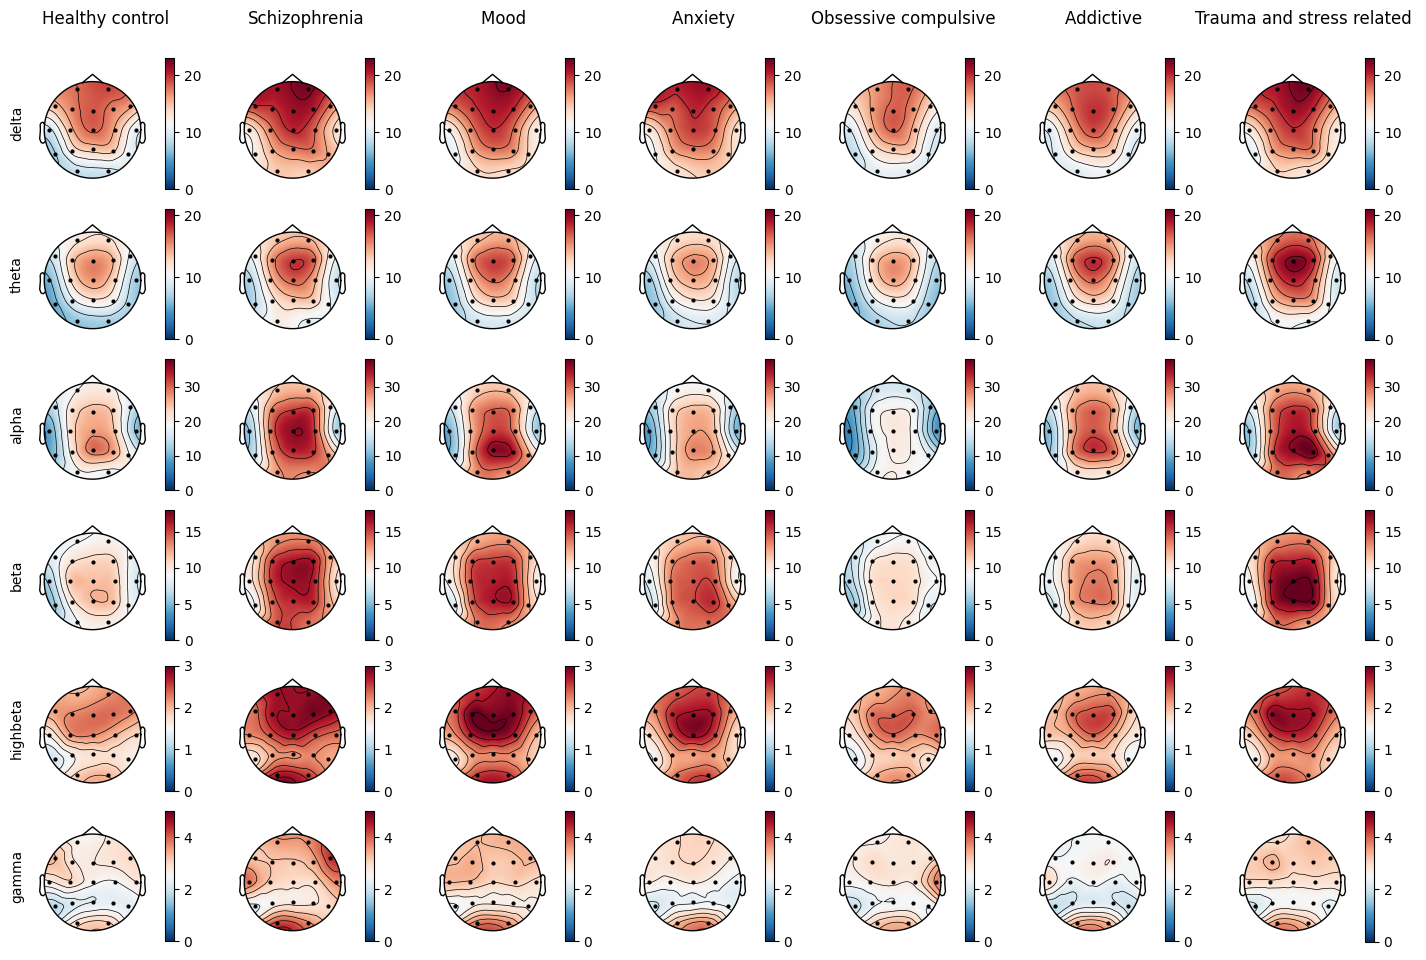

In [136]:
plt.style.use('default')
# order conditions (main.disorder)
targets = ['Healthy control',
         'Schizophrenia', 
         'Mood disorder', 
         'Anxiety disorder',  
         'Obsessive compulsive disorder', 
         'Addictive disorder',
         'Trauma and stress related disorder']
conds_labs = [x.replace('disorder', '') for x in targets]

# plot the eeg dataset
plot_eeg_dataset(main_disorder_mean, channels, conditions_ordered=targets, condition_labels=conds_labs)
plt.savefig('foo.png', bbox_inches='tight')
plt.show()

Observations:

- We can see that in comparison to the plot for disorder data, the healthy control data does not display as many neuron activation (shown with red)
- We can observe that for different disorders, different band seems to light up more.

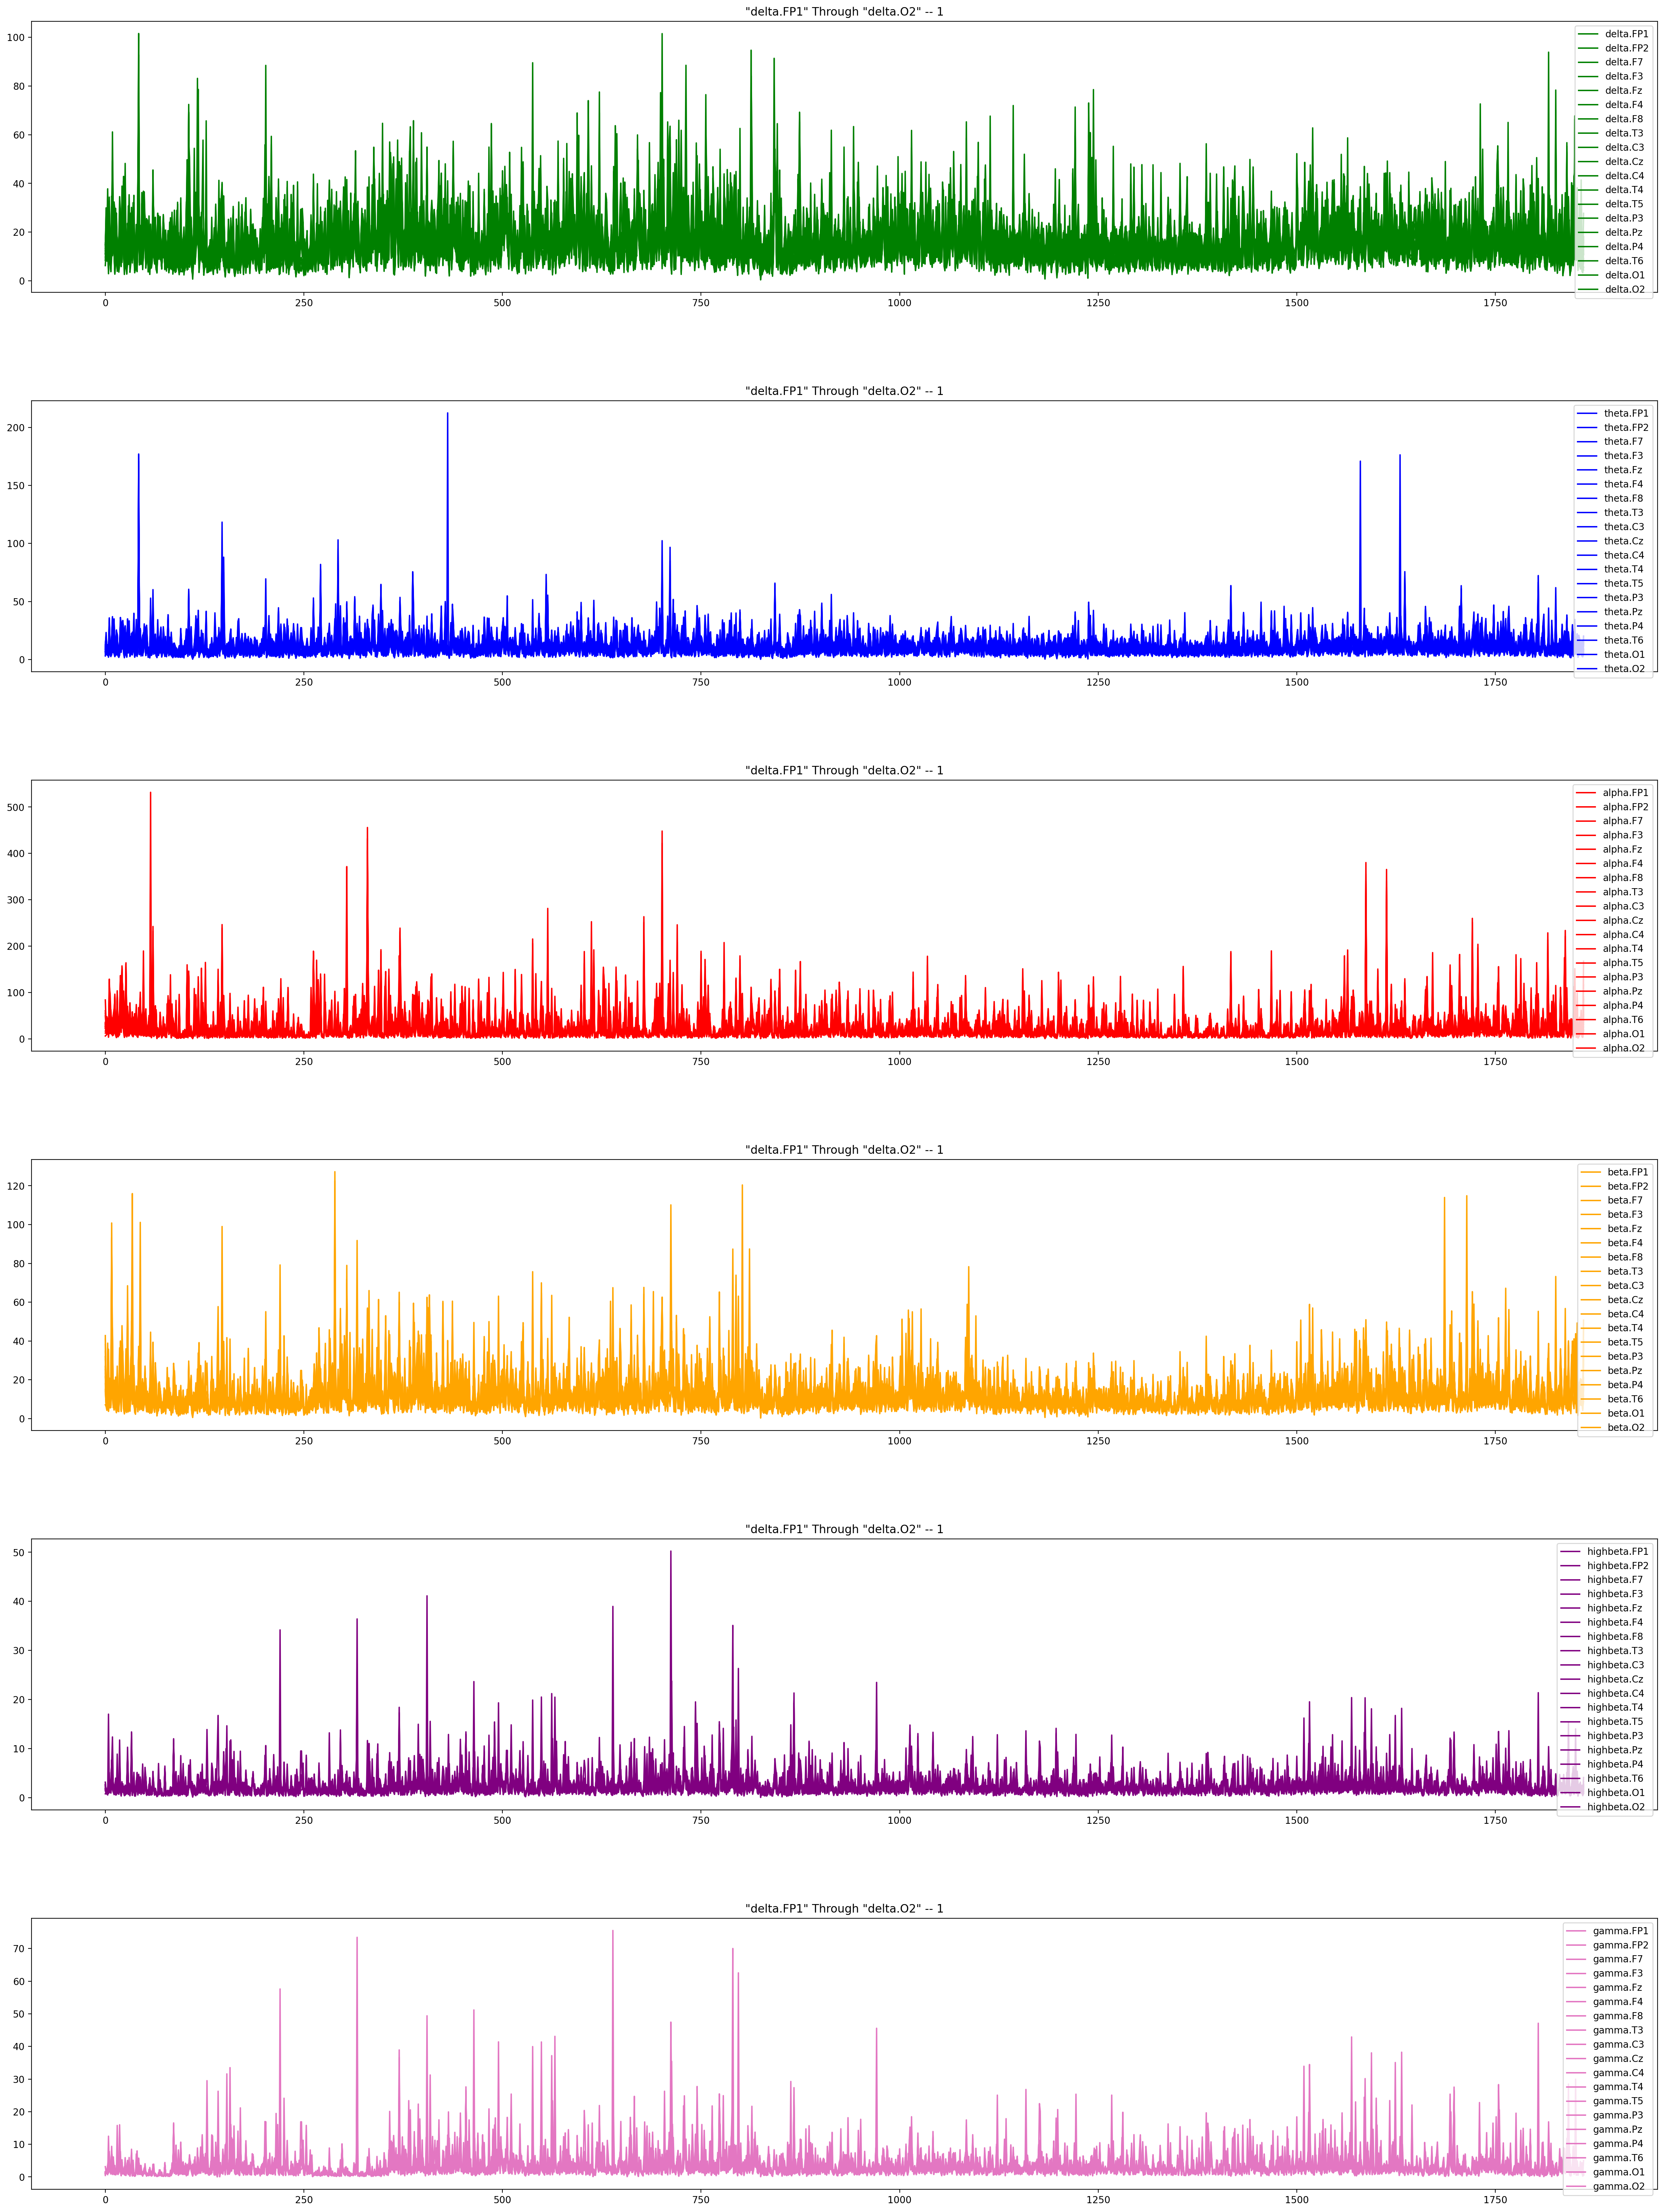

In [114]:
fig, axes = plt.subplots(nrows=6, ncols=1, dpi=200, figsize=(30, 40))

# all bands plot
df.loc[:, 'delta.FP1':'delta.O2'].plot(title='\"delta.FP1\" Through \"delta.O2\" -- 1', color='green', ax=axes[0])
df.loc[:, 'theta.FP1':'theta.O2'].plot(title='\"delta.FP1\" Through \"delta.O2\" -- 1', color='blue', ax=axes[1])
df.loc[:, 'alpha.FP1':'alpha.O2'].plot(title='\"delta.FP1\" Through \"delta.O2\" -- 1', color='red', ax=axes[2])
df.loc[:, 'beta.FP1':'beta.O2'].plot(title='\"delta.FP1\" Through \"delta.O2\" -- 1', color='orange', ax=axes[3])
df.loc[:, 'highbeta.FP1':'highbeta.O2'].plot(title='\"delta.FP1\" Through \"delta.O2\" -- 1', color='purple', ax=axes[4])
df.loc[:, 'gamma.FP1':'gamma.O2'].plot(title='\"delta.FP1\" Through \"delta.O2\" -- 1', color='tab:pink', ax=axes[5])


plt.subplots_adjust(left=0.1, bottom=0.1, 
                    right=0.9, top=0.9, 
                    wspace=0.4, hspace=0.4)
plt.savefig('signal.png', bbox_inches='tight')
plt.show()

- Above we can see the simple visualization for all the signal distribution from each band. 